In [1]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import random as rn
from heapq import nlargest

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import community as community_louvain

In [2]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [3]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [4]:
# some basic information
print('number of nodes of G0:',G0.number_of_nodes())
print('number of edges of G0:',G0.number_of_edges())
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

number of nodes of G0: 6394
number of edges of G0: 120009
Is the full G0 connected? False
How many connected subgraphs are there? 441


In [5]:
#get the largest component
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc)
print('Type',type(largest_cc))
print('number of nodes of largest connected subgraph of G:',G.number_of_nodes())
print('number of edges of largest connected subgraph of G0:',G.number_of_edges())

Type <class 'set'>
number of nodes of largest connected subgraph of G: 5932
number of edges of largest connected subgraph of G0: 119977


In [6]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

In [7]:
# new information 53343
print('number of nodes of G0 without essential nodes:',G0.number_of_nodes())
print('number of edges of G0 without essential nodes:',G0.number_of_edges())

number of nodes of G0 without essential nodes: 5098
number of edges of G0 without essential nodes: 53343


In [8]:
# narrow our selection to the proteins connected to ours
nodes = nx.shortest_path(G0,'4932.YKL126W').keys()
G=G0.subgraph(nodes)

In [9]:
# nodes = nx.shortest_path(G0,'4932.YKL126W','4932.YDR005C')
# nodes

In [10]:
# some basic information #3
print('number of nodes of G:',G.number_of_nodes())
print('number of edges of G:',G.number_of_edges())

number of nodes of G: 4639
number of edges of G: 53312


In [11]:
# nx.diameter(G)
#=8

In [56]:
# time to define a parent class of network
class Network:
    R = 1
    N = 10

    def __init__(self, graph, homologue='4932.YKL126W', partition_method="nx_louvain"):
        self.graph = graph
        self.homologue = homologue
        self.partition_method = partition_method

        self.partitions = []
        self.homologue_communities = []
        self.homologue_members={}
        self.central_nodes = [] # { encoding : centrality }
        self.important_nodes = {}
        self.homologue_index=[]
        self.community_neighbours=[]
        self.adjacent_communities = []
        self.central_nodes_neighbour = [] 
        self.important_nodes_neighbour = {}


        self.set_partitions_robust()
        self.set_homologue_communities()
        
        
        self.find_neighbours()
        self.set_neighbour_communities()
        self.set_central_nodes_robust()
        self.set_important_nodes()
        self.set_important_nodes_neighbour()

        self.count_homologue_comm_members()

    def set_partitions_robust(self):
        def find_partition(graph, partition_method, s):
            if partition_method == "nx_louvain":
                return nx_comm.louvain_communities(
                    graph, resolution=Network.R, seed=s)

            if partition_method == "other_louvain":
                # some kind of community collection
                """
                def community_collector(self,comm):
                    number_of_communities = max(comm.values())+1
                    communities = {} #empty dictionary
                    for i in range(number_of_communities):
                        communities[i] = [] #create an empty list for each community
                    for name, community in comm.items():
                        communities[community].append(name) 
                    return communities
                """
                return None

        for i in range(Network.N):
            self.partitions.append(find_partition(
                self.graph, self.partition_method, i))

    def set_homologue_communities(self):
        for part in self.partitions:
            for i in range(len(part)):
                if self.homologue in part[i]:
                    sub = self.graph.subgraph(part[i])
                    self.homologue_communities.append(sub)
                    self.homologue_index.append(i)
                    break
    
    def count_homologue_comm_members(self):
        homo_networks=map(lambda x: self.graph.subgraph(x).nodes,self.homologue_communities)
        flat_comm_nodes = [y for x in homo_networks for y in x]
        for node in flat_comm_nodes:
            if node not in self.homologue_members:
                self.homologue_members[node]=flat_comm_nodes.count(node)
        return None

    def set_central_nodes_robust(self):
        def find_central_nodes(community,n=5):
            """return a list of the most significant nodes according to three centrality measures"""
            a= nx.degree_centrality(community)
            b= nx.betweenness_centrality(community)
            c= nx.eigenvector_centrality(community)
            a5=nlargest(n, a, key = a.get)
            b5=nlargest(n, b, key = b.get)
            c5=nlargest(n, c, key = c.get)
            return list({*a5,*b5,
            *c5
            })
        
        def find_c_nodes_neighbour(community):
            if len(community)<=3:
                return []
            a= nx.degree_centrality(community)
            b= nx.betweenness_centrality(community)
            
            a5=nlargest(3, a, key = a.get)
            b5=nlargest(3, b, key = b.get)
            
            return list({*a5,*b5
            })

        for i in range(Network.N):
            self.central_nodes.append(
                find_central_nodes(self.homologue_communities[i]))
            
            neigh_networks=map(self.graph.subgraph,self.adjacent_communities[i])
            
            cen_neigh=map(find_c_nodes_neighbour,neigh_networks)
            self.central_nodes_neighbour.append(cen_neigh)

        
      

    def set_important_nodes(self):
        # flatten the central nodes list
        flat_central_nodes = [y for x in self.central_nodes for y in x]
        for node in flat_central_nodes:
            if node not in self.important_nodes:
                self.important_nodes[node]={"times_occured":flat_central_nodes.count(node),"distance":len(nx.shortest_path(self.graph,source=self.homologue,
                target=node))}

    def set_important_nodes_neighbour(self):
        # flatten the central nodes list
        flat_central_nodes_1 = [y for x in self.central_nodes_neighbour for y in x]
        flat_central_nodes_2 = [y for x in flat_central_nodes_1 for y in x]
        for node in flat_central_nodes_2:
            if node not in self.important_nodes:
                self.important_nodes_neighbour[node]={"times_occured":flat_central_nodes_2.count(node),"distance":len(nx.shortest_path(self.graph,source=self.homologue,
                target=node))}   
    
    def find_neighbours(self):
        for comm in self.homologue_communities:
            nodes=comm.nodes
            neighs=set()
            for n in nodes:
                neighs.update([*self.graph.neighbors(n)])
            self.community_neighbours.append(neighs)


    def set_neighbour_communities(self):
        a=self.partitions.copy()
        for i,part in enumerate(a):
            del part[self.homologue_index[i]]
            neighs=self.community_neighbours[i]
            nei_comm=[]
            for comm in part:
                for n in comm:
                    if n in neighs:
                        nei_comm.append(comm)
                        break
            self.adjacent_communities.append(nei_comm)
        return None

    def get_partitions(self):
        return self.partitions

    def get_homologue_communities(self):
        return self.homologue_communities

    def get_central_nodes(self):
        return self.central_nodes
    
    def get_important_nodes(self):
        return self.important_nodes

In [44]:
protein=Network(G,homologue='4932.YKL126W')

In [51]:
subnet_nodes=[*{node:protein.homologue_members[node] for node in protein.homologue_members if protein.homologue_members[node]>=7}.keys()]

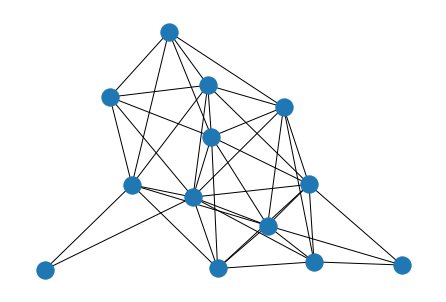

In [53]:
subnet=G.subgraph(subnet_nodes)
nx.draw(subnet)

In [14]:
protein.important_nodes_neighbour

{'4932.YPR051W': {'times_occured': 1, 'distance': 3},
 '4932.YLR244C': {'times_occured': 1, 'distance': 4},
 '4932.YDL040C': {'times_occured': 1, 'distance': 4},
 '4932.YOR253W': {'times_occured': 1, 'distance': 4},
 '4932.YHR013C': {'times_occured': 1, 'distance': 4},
 '4932.YOL058W': {'times_occured': 6, 'distance': 4},
 '4932.YHR018C': {'times_occured': 6, 'distance': 4},
 '4932.YJR109C': {'times_occured': 6, 'distance': 4},
 '4932.YGL117W': {'times_occured': 5, 'distance': 5},
 '4932.YMR062C': {'times_occured': 3, 'distance': 5},
 '4932.YNR050C': {'times_occured': 5, 'distance': 4},
 '4932.YIR034C': {'times_occured': 5, 'distance': 5},
 '4932.YDR234W': {'times_occured': 2, 'distance': 4},
 '4932.YBR263W': {'times_occured': 10, 'distance': 4},
 '4932.YLR058C': {'times_occured': 10, 'distance': 4},
 '4932.YBR084W': {'times_occured': 2, 'distance': 4},
 '4932.YJR130C': {'times_occured': 2, 'distance': 5},
 '4932.YPL273W': {'times_occured': 9, 'distance': 5},
 '4932.YER091C': {'times_o

In [15]:
protein.important_nodes

{'4932.YJL058C': {'times_occured': 9, 'distance': 2},
 '4932.YDR005C': {'times_occured': 4, 'distance': 3},
 '4932.YMR104C': {'times_occured': 10, 'distance': 2},
 '4932.YJR066W': {'times_occured': 10, 'distance': 2},
 '4932.YIL105C': {'times_occured': 10, 'distance': 2},
 '4932.YHR205W': {'times_occured': 5, 'distance': 3},
 '4932.YKL126W': {'times_occured': 10, 'distance': 1},
 '4932.YDR490C': {'times_occured': 4, 'distance': 2},
 '4932.YGR038W': {'times_occured': 2, 'distance': 2},
 '4932.YMR103C': {'times_occured': 3, 'distance': 2},
 '4932.YBR013C': {'times_occured': 1, 'distance': 2},
 '4932.YLR350W': {'times_occured': 1, 'distance': 2}}

In [17]:
protein.important_nodes

{'4932.YJL058C': {'times_occured': 9, 'distance': 2},
 '4932.YDR005C': {'times_occured': 4, 'distance': 3},
 '4932.YMR104C': {'times_occured': 10, 'distance': 2},
 '4932.YJR066W': {'times_occured': 10, 'distance': 2},
 '4932.YIL105C': {'times_occured': 10, 'distance': 2},
 '4932.YHR205W': {'times_occured': 5, 'distance': 3},
 '4932.YKL126W': {'times_occured': 10, 'distance': 1},
 '4932.YDR490C': {'times_occured': 4, 'distance': 2},
 '4932.YGR038W': {'times_occured': 2, 'distance': 2},
 '4932.YMR103C': {'times_occured': 3, 'distance': 2},
 '4932.YBR013C': {'times_occured': 1, 'distance': 2},
 '4932.YLR350W': {'times_occured': 1, 'distance': 2}}

In [18]:
protein.homologue_index

[381, 305, 543, 506, 289, 456, 241, 213, 208, 246]

In [19]:
protein.partitions

[[{'4932.Q0010',
   '4932.Q0017',
   '4932.Q0032',
   '4932.Q0092',
   '4932.Q0142',
   '4932.Q0143',
   '4932.Q0182',
   '4932.Q0297',
   '4932.YDL114W',
   '4932.YDR541C',
   '4932.YNR064C'},
  {'4932.YBR031W'},
  {'4932.Q0160', '4932.YOR033C'},
  {'4932.YDR012W'},
  {'4932.YBL091C',
   '4932.YCR020C-A',
   '4932.YDL040C',
   '4932.YEL053C',
   '4932.YGR212W',
   '4932.YHR013C',
   '4932.YHR112C',
   '4932.YLR244C',
   '4932.YMR069W',
   '4932.YNR029C',
   '4932.YOL076W',
   '4932.YOR253W',
   '4932.YPR051W',
   '4932.YPR131C'},
  {'4932.YML063W'},
  {'4932.YLR441C'},
  {'4932.YDL202W', '4932.YPL270W'},
  {'4932.YGR033C', '4932.YJL166W', '4932.YKR065C', '4932.YPL098C'},
  {'4932.YPR166C'},
  {'4932.YDL189W', '4932.YPR191W'},
  {'4932.YKL056C'},
  {'4932.YBR185C',
   '4932.YDL107W',
   '4932.YER154W',
   '4932.YGR062C',
   '4932.YOL027C',
   '4932.YOR266W'},
  {'4932.Q0055',
   '4932.Q0060',
   '4932.Q0105',
   '4932.Q0110',
   '4932.Q0115',
   '4932.Q0120',
   '4932.YBR120C',
   '493

In [20]:
len([*G.neighbors("4932.YKL126W")])

35

In [21]:
nodes_n=protein.adjacent_communities[0]
"4932.YKL126W" in [y for x in nodes_n for y in x]

False

In [22]:
len(nodes_n)

64

In [23]:
a=protein.partitions[0]
len(a)

603

In [57]:
ypk1=Network(G,homologue='4932.YKL126W')

In [58]:
ypk1.get_important_nodes()

{'4932.YGR040W': {'times_occured': 9, 'distance': 4},
 '4932.YJR066W': {'times_occured': 9, 'distance': 2},
 '4932.YLR113W': {'times_occured': 9, 'distance': 3},
 '4932.YBL016W': {'times_occured': 9, 'distance': 4},
 '4932.YLR362W': {'times_occured': 9, 'distance': 3},
 '4932.YHR030C': {'times_occured': 9, 'distance': 3},
 '4932.YDR477W': {'times_occured': 9, 'distance': 3},
 '4932.YNL098C': {'times_occured': 7, 'distance': 3},
 '4932.YHL007C': {'times_occured': 7, 'distance': 3},
 '4932.YMR307W': {'times_occured': 4, 'distance': 3},
 '4932.YLR433C': {'times_occured': 5, 'distance': 3},
 '4932.YKL113C': {'times_occured': 1, 'distance': 4},
 '4932.YHL022C': {'times_occured': 1, 'distance': 4},
 '4932.YML032C': {'times_occured': 1, 'distance': 4},
 '4932.YBR010W': {'times_occured': 1, 'distance': 3},
 '4932.YMR190C': {'times_occured': 1, 'distance': 4},
 '4932.YER095W': {'times_occured': 1, 'distance': 3},
 '4932.YOR033C': {'times_occured': 1, 'distance': 4},
 '4932.YOL012C': {'times_occ

In [72]:
subnet_nodes=[*{node:ypk1.homologue_members[node] for node in ypk1.homologue_members if ypk1.homologue_members[node]>=9}.keys()]

In [73]:
len(subnet_nodes)

355

In [74]:
subnet=G.subgraph(subnet_nodes)

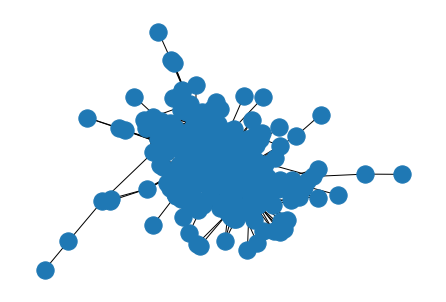

In [75]:
nx.draw(subnet)